In [1]:
import os, shutil, copy, ntpath
from keras import models
from keras import layers


/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#directory definitions
# this code has changed since last tested/used

#original_dataset_dir = r'C:\Users\aln15\Documents\SMUHomeWork\Capstone\asl_alphabet_train\asl_alphabet_train'
base_dir =  '../data/original/asl_alphabet'
#base_dir = 'C:/Users/aln15/Documents/SMUHomeWork/Capstone/handsigns'

#os.mkdir(base_dir)

train_dir = os.path.join(base_dir,'train_asl')

#os.mkdir(train_dir)

validation_dir = os.path.join(base_dir,'validation_asl')
#os.mkdir(validation_dir)


test_dir = os.path.join(base_dir,'test_asl')
#os.mkdir(test_dir)


   # copy datafiles into directory structure for modelling
   #untested since last change

asl_folders = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','del','space','nothing']


for signFolder in range (len(asl_folders)):
   sign_dir = os.path.join(original_dataset_dir, asl_folders[signFolder])
   letter_folder = os.path.join(asl_folders[signFolder] + str("\\"))

   test_out_dir = ntpath.dirname(os.path.join(test_dir, letter_folder))
   #os.mkdir(test_out_dir)

   val_out_dir = ntpath.dirname(os.path.join(var_dir, letter_folder))
   #os.mkdir(val_out_dir)

   train_out_dir = ntpath.dirname(os.path.join(train_dir, letter_folder))
    #os.mkdir(train_out_dir)

for fileCounter in range (3000,3001):
        fname = asl_folders[signFolder]+str(fileCounter) + '.jpg'
        src = os.path.join(sign_dir,fname)
        
        if fileCounter <=1200:
            dat = ntpath.dirname(os.path.join(train_out_dir))
        if fileCounter > 1200 and fileCounter <=1950: 
            dat = ntpath.dirname(os.path.join(validation_out_dir))
        if fileCounter > 1950 and fileCounter <=3000:
            dat = ntpath.dirname(os.path.join(test_out_dir))
                     
        shutil.copy(src, out_dir)
        #print("Source: ", src, "Destination: ", out_dir)

    # 29 signs                      
    # number of training samples/sign = 1749
    # number of validation samples/sign = 501
    # number of test samples/sign = 750
    # of training samples total = 50,721
    # of validation samples total = 14,429
    # of test samples total = 21,750
    
    # balanced multi-class problem
    #classification accuracy is the appropriate measure of success
    
    #network architecture notes
    # final layer will have density size of 29 (number of signs) and activation of softmax 
    #Convnet = stack of alternated Conv2D (with relu activation and MaxPooling2D layers
    #one layer of Conv2D + MaxPooling2D  (increases the capacity of the netwwork and reduces the size of the feature maps prior     #to the Flatten layer
    #input size of 28 x 28
    

In [3]:
#data generation setip
import keras
from keras.preprocessing.image import ImageDataGenerator
#image size (original = 28)
tarsize = 150
batchsize = 20

# for tensorboard display (doesn't work yet)
my_log_dir = ntpath.dirname(r'C:\Users\aln15\Documents\SMUHomeWork\Capstone\hsmodellogs')
#os.mkdir(my_log_dir)
tensorboard = keras.callbacks.TensorBoard(
    log_dir=my_log_dir,
    histogram_freq=1,
    write_images=True)


#augnmentation
train_datagen = ImageDataGenerator(
           rotation_range = 0,
           width_shift_range = .2,
           height_shift_range = .2,
           shear_range = .2,
           zoom_range = .2,
           horizontal_flip = False,
           fill_mode = 'nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)
#---------end augmentation 

In [4]:
# dataset definition without augmentation
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# end without augmentation

In [5]:
#create generators
train_generator = train_datagen.flow_from_directory(
           base_dir,
           target_size = (tarsize, tarsize),
           batch_size=batchsize,
           class_mode = 'categorical'
)


Found 86987 images belonging to 29 classes.



validation_generator = train_datagen.flow_from_directory(
         validation_dir,
         target_size = (tarsize,tarsize),
         batch_size = batchsize,
         class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
         test_dir,
         target_size = (tarsize,tarsize),
         batch_size = batchsize,
         class_mode='categorical'
)


#------end of dataset definitions 

In [9]:
#modelling...setup, definition, compile, run and test

callbacks_list = [
 #        tensorboard,
         keras.callbacks.EarlyStopping(monitor='acc', patience=2),
         keras.callbacks.ModelCheckpoint(filepath = '../data/models/handsigns/handsigns.h5', monitor = 'val_loss', save_best_only = True),
         keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor = 0.1, patience=10)
]


model = models.Sequential()
model.add(layers.Conv2D(16, (3, 3), activation='relu', input_shape=(tarsize, tarsize, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (3, 3), activation='relu'))

#Add a classfier on top of the convnet
model.add(layers.Flatten())
model.add(layers.Dropout(.5))
model.add(layers.Dense(128, activation='relu'))
#model.add(layers.BatchNormalization())
model.add(layers.Dense(29, activation='softmax'))

#compile the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)       73856     
__________

In [10]:
history= model.fit_generator (
           train_generator,
           # steps_per_epoch = 100,
           epochs = 10,
           callbacks = callbacks_list,
           #validation_data=validation_generator,
           verbose=1,
           #shuffle = FALSE,
           #validation_split=.1,
           validation_steps = 50)




#test_loss, test_acc = model.evaluate_generator(test_generator,steps=50)
#print('test_acc: ',test_acc)

#save the model
model.save('../data/models/handsigns/handsigns_try2aug.h5')



Epoch 1/10
4350/4350 [==============================] - 1507s 346ms/step - loss: 0.6973 - acc: 0.7858
Epoch 2/10


/usr/local/lib/python3.6/site-packages/keras/callbacks.py:432: RuntimeWarning: Can save best model only with val_loss available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)
/usr/local/lib/python3.6/site-packages/keras/callbacks.py:1043: RuntimeWarning: Reduce LR on plateau conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


4350/4350 [==============================] - 1510s 347ms/step - loss: 0.1345 - acc: 0.9643
Epoch 3/10
4350/4350 [==============================] - 1496s 344ms/step - loss: 0.1180 - acc: 0.9744
Epoch 4/10
4350/4350 [==============================] - 1492s 343ms/step - loss: 0.1426 - acc: 0.9765
Epoch 5/10
4350/4350 [==============================] - 1488s 342ms/step - loss: 0.1786 - acc: 0.9781
Epoch 6/10
4350/4350 [==============================] - 1524s 350ms/step - loss: 0.2723 - acc: 0.9755
Epoch 7/10
4350/4350 [==============================] - 1491s 343ms/step - loss: 0.4677 - acc: 0.9657


NameError: name 'val_loss_values' is not defined

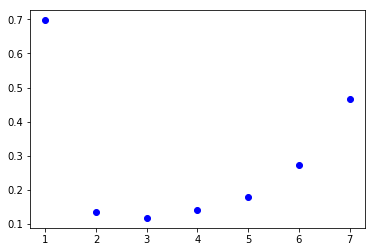

In [12]:
#visualization of model performance
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss']
#val_loss_values =  history_dict['val_loss']
acc_values = history_dict['acc']

epochs = range(1, len(acc_values) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training Loss')
plt.plot(epochs,val_loss_values, 'b', label = 'Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel='Epochs'
plt.ylabel='Loss'
plt.legend()

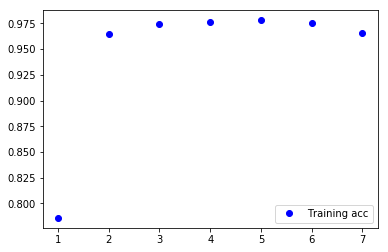

In [14]:
plt.clf()
acc_values = history_dict['acc']
#val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
#plt.plot(epochs,val_acc_values, 'b', label='Validation accuracy')
plt.xlabel = 'Epochs'
plt.ylabel = 'Loss'
plt.legend()

plt.show()